In [105]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [106]:
import sys
sys.path.append('./')
import json
import os
import qiskit
from qiskit import QuantumCircuit
import numpy as np
from dataclasses import dataclass
from enum import auto, Enum
import matplotlib.pyplot as plt
import math
import pandas as pd
from qiskit.visualization import plot_error_map
from component.a_backend.fake_backend import *
from mqt.bench.targets import get_available_gateset_names, get_available_device_names
from mqt.bench import BenchmarkLevel, get_benchmark
from mqt.bench.targets import get_device, get_target_for_gateset
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.transpiler import generate_preset_pass_manager
from qiskit.circuit import QuantumCircuit
from qiskit.visualization import plot_histogram
from component.sup_sys.backend_loader import load_backends
from qiskit.visualization import plot_error_map
from component.c_circuit_work.knitting.width_k import *
from qiskit.transpiler import *
from qiskit.visualization import plot_circuit_layout

6


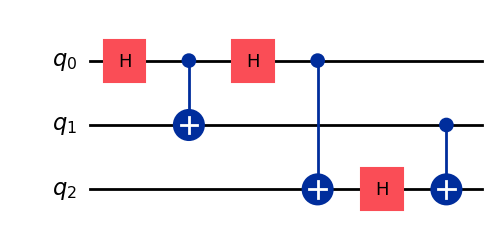

In [107]:
circuit0 = QuantumCircuit(3)
circuit0.h(0)
circuit0.cx(0, 1)
circuit0.h(0)
circuit0.cx(0, 2)
circuit0.h(2)
circuit0.cx(1, 2)
print(circuit0.depth())
circuit0.draw('mpl')

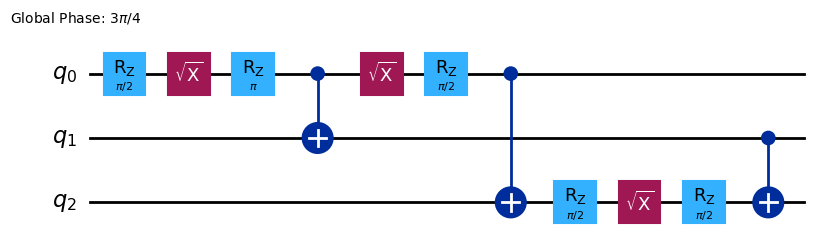

In [108]:
transpiled = transpile(circuit0, basis_gates=['sx', 'cx', 'rz'], optimization_level=3)
transpiled.draw('mpl')

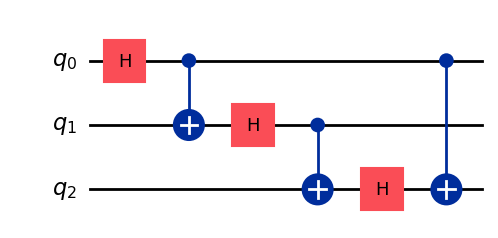

In [109]:
circuit1 = QuantumCircuit(3)
circuit1.h(0)
circuit1.cx(0, 1)
circuit1.h(1)
circuit1.cx(1, 2)
circuit1.h(2)
circuit1.cx(0, 2)
circuit1.__init__
circuit1.draw('mpl')

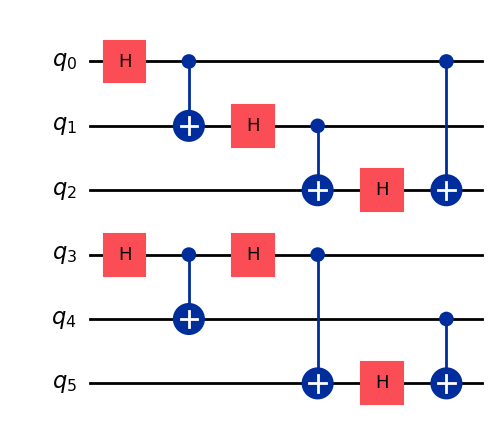

In [110]:
backendtest = FakeOslo()
new_circuit = expand_circuit_width(circuit0, circuit1)
new_circuit.draw('mpl')

12


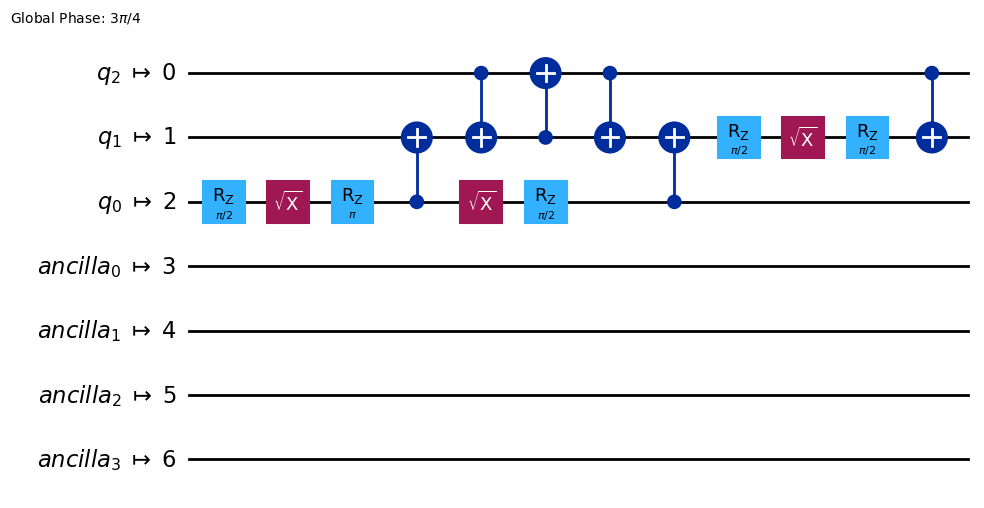

In [111]:
transpile_circuit_0 = transpile(circuit0, backend=backendtest, optimization_level=3)
print(transpile_circuit_0.depth())
transpile_circuit_0.draw('mpl')

11


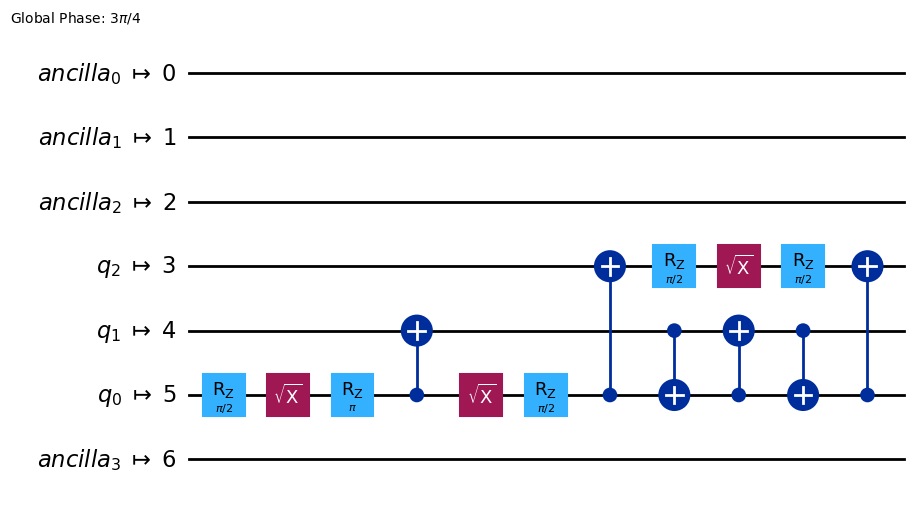

In [112]:
transpile_circuit_0 = transpile(circuit0, backend=backendtest, optimization_level=3)
print(transpile_circuit_0.depth())
transpile_circuit_0.draw('mpl')

13


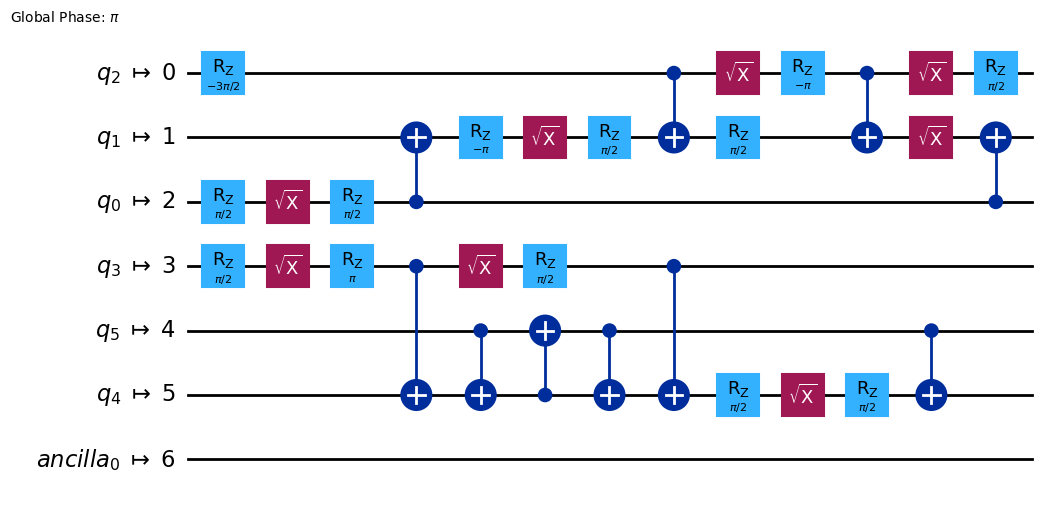

In [113]:
transpile_circuit_merge = transpile(new_circuit, backend=backendtest, optimization_level=3)
print(transpile_circuit_merge.depth())
transpile_circuit_merge.draw('mpl')

In [ ]:
backend0 = FakeAthensV2() # chu M nguoc 
backend1 = FakeBelemV2() # W huyen
backend2 = FakeBurlingtonV2() # W huyen
backend3 = FakeYorktownV2() # connection
list_backend = [backend0, backend1, backend2, backend3]

results = []

for backend in list_backend:
    for opt_level in [0, 1, 2, 3]:
            # Circuit 2
            depth_before_2 = circuit0.depth()
            transpiled_2 = transpile(circuit0, backend=backend, optimization_level=opt_level, scheduling_method="asap")
            depth_after_2 = transpiled_2.depth()
            results.append({
                'circuit': 'case0',
                'backend': backend.name,
                'optimization_level': opt_level,
                'scheduling_method': "asap",
                'depth_before': depth_before_2,
                'depth_after': depth_after_2
            })
            # Circuit 3
            depth_before_3 = circuit1.depth()
            transpiled_3 = transpile(circuit1, backend=backend, optimization_level=opt_level, scheduling_method="asap")
            depth_after_3 = transpiled_3.depth()
            results.append({
                'circuit': 'case1',
                'backend': backend.name,
                'optimization_level': opt_level,
                'scheduling_method': "asap",
                'depth_before': depth_before_3,
                'depth_after': depth_after_3
            })

df_depth = pd.DataFrame(results)
# save results to CSV
df_depth.to_csv('depth_results.csv', index=False)

In [116]:
# Load the data and prepare for visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Load the depth results
df_depth = pd.read_csv('depth_results.csv')

# Clean backend names for better visualization
df_depth['backend_clean'] = df_depth['backend'].str.replace('fake_', '').str.title()

# Calculate average depth_after for each case and backend across all optimization levels
avg_depth = df_depth.groupby(['circuit', 'backend_clean'])['depth_after'].mean().reset_index()

# Pivot for easier plotting
avg_depth_pivot = avg_depth.pivot(index='backend_clean', columns='circuit', values='depth_after')

print("Data loaded and prepared successfully!")
print(f"Backends analyzed: {list(df_depth['backend_clean'].unique())}")
print(f"Circuits analyzed: {list(df_depth['circuit'].unique())}")
print(f"Optimization levels: {sorted(df_depth['optimization_level'].unique())}")

Data loaded and prepared successfully!
Backends analyzed: ['Athens', 'Belem', 'Burlington', 'Yorktown']
Circuits analyzed: ['case0', 'case1']
Optimization levels: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]


Plot saved as 'img/avg_depth_comparison.png' and 'img/avg_depth_comparison.pdf'


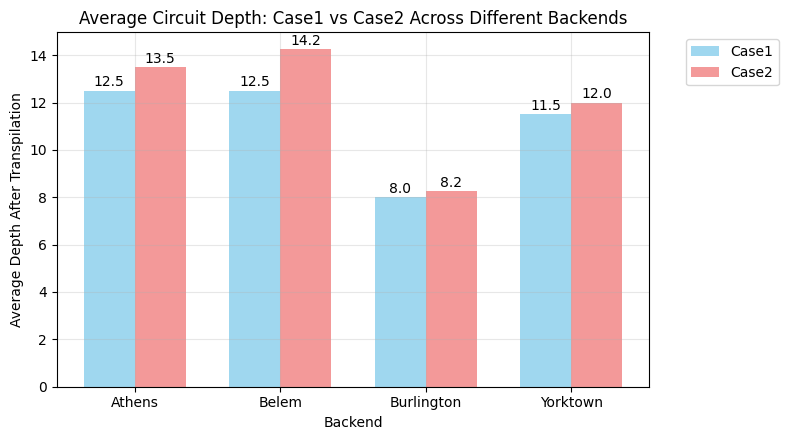

In [117]:
# Plot 1: Bar chart comparing average depths
plt.figure(figsize=(8, 4.5))

x = np.arange(len(avg_depth_pivot.index))
width = 0.35

bars1 = plt.bar(x - width/2, avg_depth_pivot['case0'], width, label='Case1', alpha=0.8, color='skyblue')
bars2 = plt.bar(x + width/2, avg_depth_pivot['case1'], width, label='Case2', alpha=0.8, color='lightcoral')

plt.xlabel('Backend')
plt.ylabel('Average Depth After Transpilation')
plt.title('Average Circuit Depth: Case1 vs Case2 Across Different Backends')
plt.xticks(x, avg_depth_pivot.index, rotation=0, fontsize=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.05,
             f'{height:.1f}', ha='center', va='bottom', fontsize=10)

for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.05,
             f'{height:.1f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()

plt.savefig('img/avg_depth_comparison.pdf', bbox_inches='tight')
print("Plot saved as 'img/avg_depth_comparison.png' and 'img/avg_depth_comparison.pdf'")

plot = plt.show()

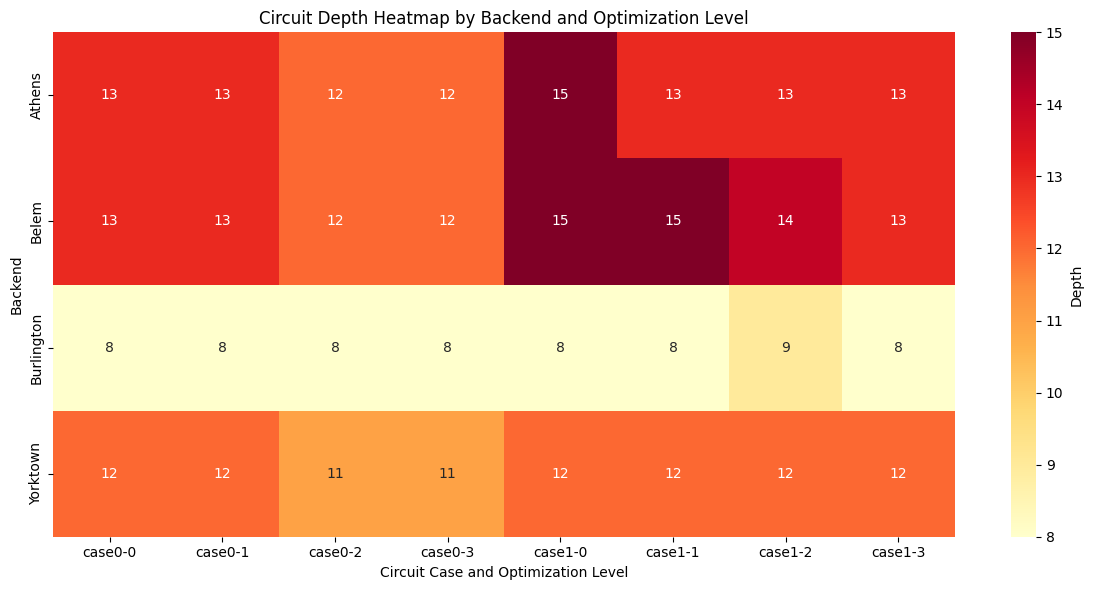

In [118]:
# Plot 2: Heatmap showing depth for each optimization level
plt.figure(figsize=(12, 6))

heatmap_data = df_depth.pivot_table(index='backend_clean', 
                                   columns=['circuit', 'optimization_level'], 
                                   values='depth_after')

sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='YlOrRd', cbar_kws={'label': 'Depth'})
plt.title('Circuit Depth Heatmap by Backend and Optimization Level')
plt.xlabel('Circuit Case and Optimization Level')
plt.ylabel('Backend')
plt.tight_layout()
plt.show()

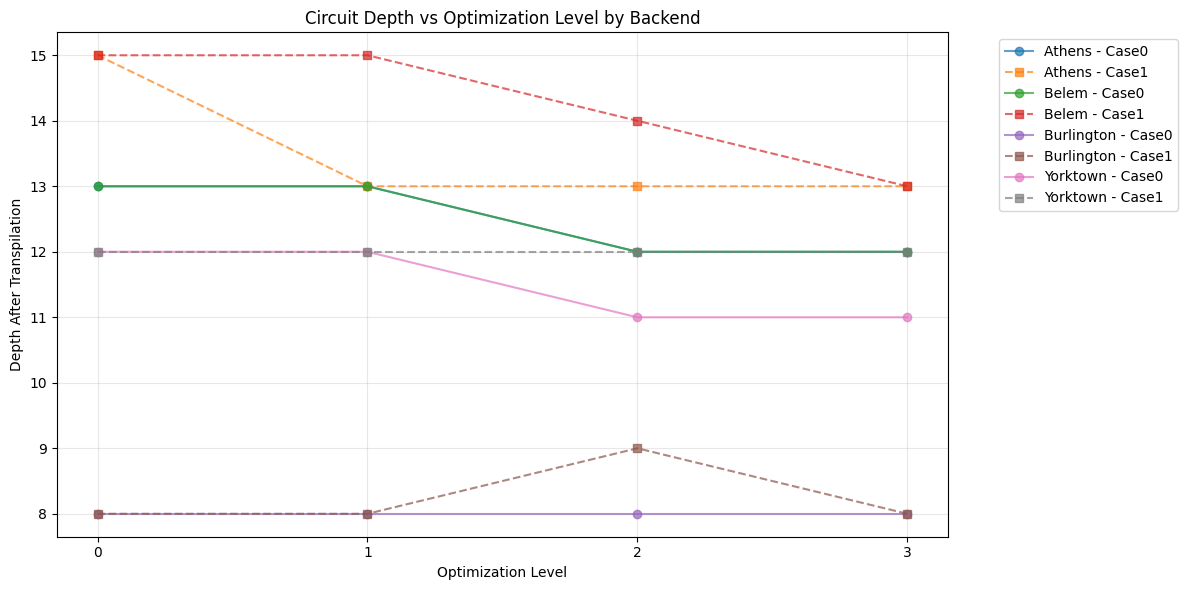

In [119]:
# Plot 3: Line plot showing optimization level effect
plt.figure(figsize=(12, 6))

for backend in df_depth['backend_clean'].unique():
    backend_data = df_depth[df_depth['backend_clean'] == backend]
    
    case0_data = backend_data[backend_data['circuit'] == 'case0']
    case1_data = backend_data[backend_data['circuit'] == 'case1']
    
    plt.plot(case0_data['optimization_level'], case0_data['depth_after'], 
             marker='o', linestyle='-', label=f'{backend} - Case0', alpha=0.7)
    plt.plot(case1_data['optimization_level'], case1_data['depth_after'], 
             marker='s', linestyle='--', label=f'{backend} - Case1', alpha=0.7)

plt.xlabel('Optimization Level')
plt.ylabel('Depth After Transpilation')
plt.title('Circuit Depth vs Optimization Level by Backend')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.xticks([0, 1, 2, 3])
plt.tight_layout()
plt.show()

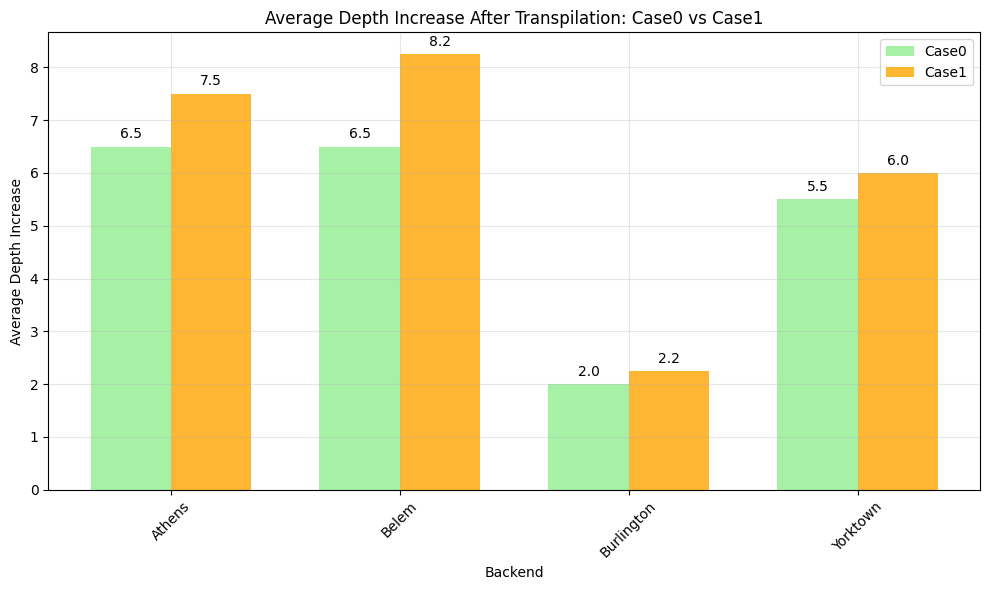

In [120]:
# Plot 4: Depth increase comparison
plt.figure(figsize=(10, 6))

depth_increase = df_depth.copy()
depth_increase['depth_increase'] = depth_increase['depth_after'] - depth_increase['depth_before']

avg_increase = depth_increase.groupby(['circuit', 'backend_clean'])['depth_increase'].mean().reset_index()
avg_increase_pivot = avg_increase.pivot(index='backend_clean', columns='circuit', values='depth_increase')

x = np.arange(len(avg_increase_pivot.index))
width = 0.35

bars1 = plt.bar(x - width/2, avg_increase_pivot['case0'], width, label='Case0', alpha=0.8, color='lightgreen')
bars2 = plt.bar(x + width/2, avg_increase_pivot['case1'], width, label='Case1', alpha=0.8, color='orange')

plt.xlabel('Backend')
plt.ylabel('Average Depth Increase')
plt.title('Average Depth Increase After Transpilation: Case0 vs Case1')
plt.xticks(x, avg_increase_pivot.index, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height:.1f}', ha='center', va='bottom', fontsize=10)

for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height:.1f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

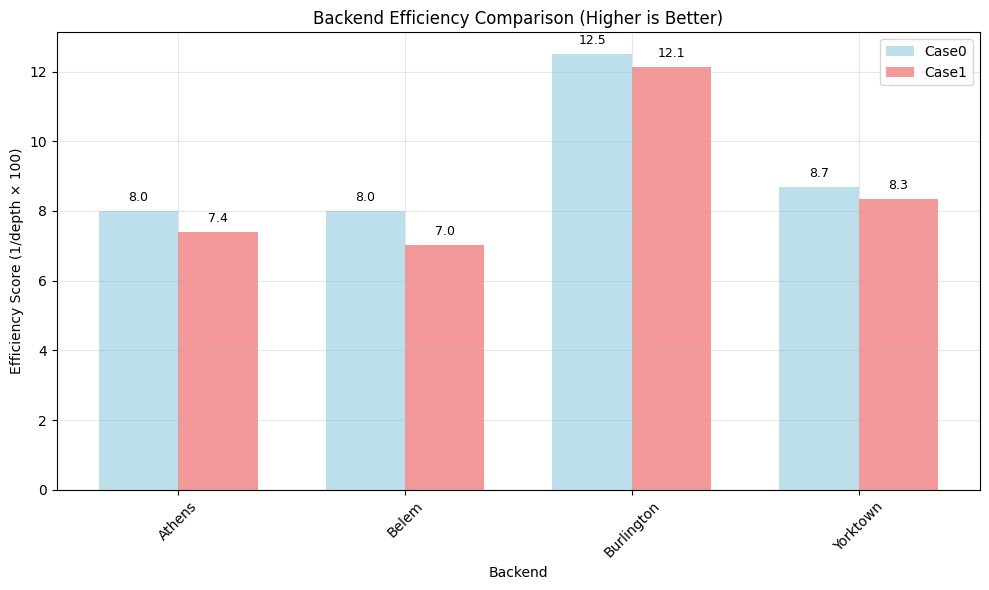

In [121]:
# Plot 5: Backend efficiency comparison
plt.figure(figsize=(10, 6))

efficiency_data = []
backends = df_depth['backend_clean'].unique()

for backend in backends:
    backend_data = df_depth[df_depth['backend_clean'] == backend]
    case0_avg = backend_data[backend_data['circuit'] == 'case0']['depth_after'].mean()
    case1_avg = backend_data[backend_data['circuit'] == 'case1']['depth_after'].mean()
    
    # Calculate efficiency as inverse of depth (lower depth = higher efficiency)
    case0_efficiency = 1/case0_avg * 100
    case1_efficiency = 1/case1_avg * 100
    
    efficiency_data.append({
        'Backend': backend,
        'Case0_Efficiency': case0_efficiency,
        'Case1_Efficiency': case1_efficiency
    })

efficiency_df = pd.DataFrame(efficiency_data)
x = np.arange(len(efficiency_df))
width = 0.35

bars1 = plt.bar(x - width/2, efficiency_df['Case0_Efficiency'], width, 
                label='Case0', color='lightblue', alpha=0.8)
bars2 = plt.bar(x + width/2, efficiency_df['Case1_Efficiency'], width, 
                label='Case1', color='lightcoral', alpha=0.8)

plt.xlabel('Backend')
plt.ylabel('Efficiency Score (1/depth × 100)')
plt.title('Backend Efficiency Comparison (Higher is Better)')
plt.xticks(x, efficiency_df['Backend'], rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# Add value labels
for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.2,
             f'{height:.1f}', ha='center', va='bottom', fontsize=9)

for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.2,
             f'{height:.1f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()